# ML Image Classification to classify whether a dog photo is Buddy or not




### Project Description:
In this notebook I will train an image classification algorithm to be able to identify if a photo of a dog is a photo of my dog (Buddy) or not. I will use the tensor flow package to train my model and I will use the sklearn library to split up my data into a train and test set. 

In [2]:
# Importing required libraries
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from sklearn.model_selection import train_test_split
import plotly.express as px
import pyheif
from PIL import Image, UnidentifiedImageError
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt



2023-12-10 11:49:52.495329: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/adriannaqueen/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [134]:
# Specify the paths to images to train
dog_photos_folder = "generic dogs"
buddy_photos_folder = 'Exported Buddy'

# Get a list of all image files in each folder
dog_photos = [os.path.join(dog_photos_folder, file) for file in os.listdir(dog_photos_folder) if file.endswith('.jpg')][0:2138] # only take a sample of 2138 photos
buddy_photos = [os.path.join(buddy_photos_folder, file) for file in os.listdir(buddy_photos_folder)]
print(f"Number of generic dog images: {len(dog_photos)}")
print(f"Number of buddy photos: {len(buddy_photos)}")

# Visualize distribution
fig = px.bar(x=['Generic Dog', 'Buddy'],
             y=[len(dog_photos), len(buddy_photos)],
             title='Generic Dog Photos vs. Buddy Photos',
             labels={'x': 'Category', 'y': 'Number of Photos'},
             color=['Generic Dog', 'Buddy'],
             color_discrete_map={'Generic Dog': 'blue', 'Buddy': 'orange'})
fig.update_layout(width=400, height=300)
fig.show()

# Assign labels to the datasets
dog_labels = ['dog'] * len(dog_photos)
buddy_labels = ['buddy'] * len(buddy_photos)

# Combine the datasets and labels
all_photos = dog_photos + buddy_photos
all_labels = dog_labels + buddy_labels

# Split the dataset into training and testing sets
train_photos, test_photos, train_labels, test_labels = train_test_split(all_photos, all_labels, test_size=0.05, random_state=42)

print(f"Number of training samples: {len(train_photos)}")
print(f"Number of testing samples: {len(test_photos)}")



Number of generic dog images: 2138
Number of buddy photos: 2138


Number of training samples: 4062
Number of testing samples: 214


## EDA Procedure
I performed multiple interations of creating this model with various different sizes for number of photos in each category. As the iterations went on, I realized that my model was performing better when I uses sample sizes that were the same

In [135]:
# Create DataFrames with file paths and labels
train_df = pd.DataFrame({'filename': train_photos, 'class': train_labels})
test_df = pd.DataFrame({'filename': test_photos, 'class': test_labels})

In [93]:
# Specify image size and batch size
img_size = (150, 150)
batch_size = 16#64 #128 changed for iteration 5 #changed from 32 at iteration 4

# Creating ImageDataGenerator with class_mode specified
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# Creating training set generator
training_set = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                 x_col='filename',
                                                 y_col='class',
                                                 target_size=img_size,
                                                 batch_size=batch_size,
                                                 class_mode='binary')

# Creating testing set generator
test_set = test_datagen.flow_from_dataframe(dataframe=test_df,
                                            x_col='filename',
                                            y_col='class',
                                            target_size=img_size,
                                            batch_size=batch_size,
                                            class_mode='binary')

print(f"Updated number of training samples: {len(training_set)}")
print(f"Updated number of testing samples: {len(test_set)}")


Found 4062 validated image filenames belonging to 2 classes.
Found 214 validated image filenames belonging to 2 classes.
Updated number of training samples: 254
Updated number of testing samples: 14


# Procedure
### Model Building and Training
This model is designed to learn from images. It takes in pictures, which are initially in a 150x150 pixel format with three color channels (red, green, and blue). The model consists of several layers that process these images. For this project, I reran my model build 8 different times. 


Here's a breakdown of the choices I made when designing this model:

Convolutional Layers (Conv2D): These layers perform operations on small pieces of the image at a time (3x3 pixel regions). The first layer looks at 32 different features, the second layer at 64 features, and the third at 128 features. These features capture different aspects of the images.

MaxPooling Layers (MaxPooling2D): After each convolutional layer, the MaxPooling layers reduce the spatial dimensions of the features. They keep the most important information and discard the less relevant parts, helping to make the model more efficient.

Flatten Layer: This layer flattens the output from the previous layers into a one-dimensional array. This prepares the data for the final classification steps.

Dense Layers (Fully Connected Layers): The flattened data is passed through two dense layers. The first dense layer has 512 neurons and applies the 'relu' activation function, which helps the model learn complex patterns in the data. The second dense layer has a single neuron with a 'sigmoid' activation, which is typical for binary classification problems. This neuron represents the output, indicating whether the model predicts class 0 or 1.

In [94]:
# Defining the model architecture
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(training_set,epochs=5)

Epoch 1/5
254/254 [==============================] - 592s 2s/step - loss: 0.2174 - accuracy: 0.9178
Epoch 2/5
254/254 [==============================] - 413s 2s/step - loss: 0.1146 - accuracy: 0.9562
Epoch 3/5
254/254 [==============================] - 409s 2s/step - loss: 0.0934 - accuracy: 0.9670
Epoch 4/5
254/254 [==============================] - 407s 2s/step - loss: 0.0723 - accuracy: 0.9739
Epoch 5/5
254/254 [==============================] - 426s 2s/step - loss: 0.0617 - accuracy: 0.9786


In [95]:
# Evaluate the model on the test set
evaluation_result = model.evaluate(test_set)

# Print the evaluation results
print(f"Test Loss: {evaluation_result[0]}")
print(f"Test Accuracy: {evaluation_result[1]}")


14/14 [==============================] - 19s 1s/step - loss: 0.0952 - accuracy: 0.9673
Test Loss: 0.09524118155241013
Test Accuracy: 0.9672897458076477


14/14 [==============================] - 24s 2s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.83      0.75       150
           1       0.26      0.14      0.18        64

    accuracy                           0.62       214
   macro avg       0.47      0.48      0.47       214
weighted avg       0.56      0.62      0.58       214



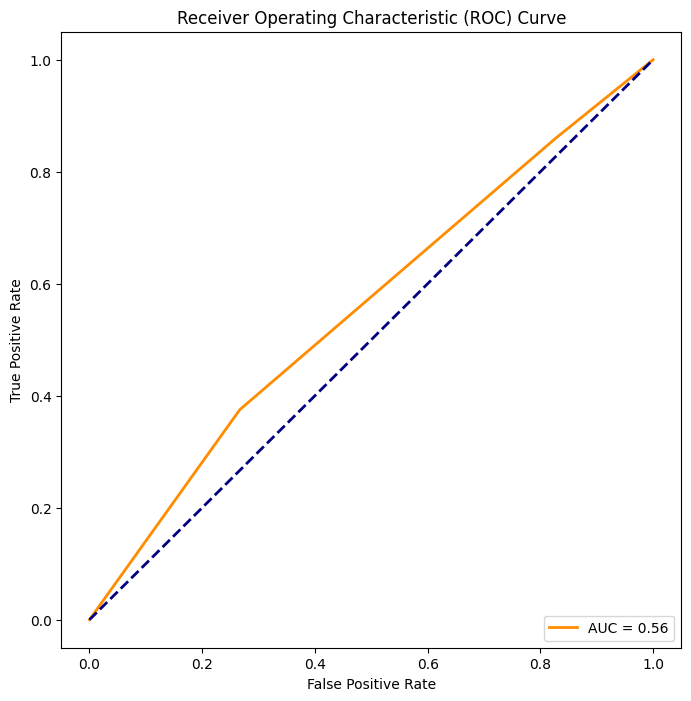

Confusion Matrix:
[[124  26]
 [ 55   9]]
Accuracy: 0.6214953271028038


In [166]:
# Generate predictions on the test set
y_pred = model.predict(test_set)

# Convert probabilities to binary predictions (0 or 1)
y_pred_binary = (y_pred < 0.5).astype(int)

y_true = test_set.classes

# Classification Report (precision, recall, F1-score)
print("Classification Report:")
print(classification_report(y_true, y_pred_binary))

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


cm = confusion_matrix(y_true, y_pred_binary)
print("Confusion Matrix:")
print(cm)


accuracy = accuracy_score(y_true, y_pred_binary)
print(f"Accuracy: {accuracy}")


# Analysis
With each model being run, I worked to improve my AUC, precision, recall, and F1-score. Whhile each iteration did not improve linearly, I was able to see how the changes I was making to my model were helping/hurting.

# Discussion/Conclusion
Unfortunately, I could only get my model to an accuracy of 62.15% and an AUC of 0.56. After many different iterations of various dataset sizes, batch sizes, epochh sizes, and number of accurate photos (Buddy photos), I was able to improve my model from a lowest accuacy of ~40% to this 62%, so I will take a 50% improvement in model accuracy.

In summary, the model performs better for classifying the generic dog photos (higher precision, recall, and F1-score) than for classifying Buddy photos. 